In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

In [3]:
#Path of the file with the data of particles
os.chdir(r'C:\Users\wdjat\Documents\Mingo\Corsika\Simu_Puebla')

In [4]:
#File with summary of Showers
Showers = pd.read_csv(r'E3_zn25_P_10k_DAT000003_showers.txt',delimiter='\t')

In [5]:
#File with information of all particles at observation level
Particles = pd.read_csv('E3_zn25_P_10k_DAT000003_particles.txt',delimiter='\t')

In [6]:
# Run summary
Energies = {'E1': 9, 'E2': 11, 'E3': 14, 'E4': 18, 'E5': 55, 'E6':70}
Run = {'SCod': 'Corsika-77500','Mass':[1],'Lab': ['BUAP'], 'NShows':[10000], 'EInf': Energies['E1'] , 'ESup': Energies['E2'], 'AAInf':[0], 'AASup':[25]} 
Run = pd.DataFrame(Run)

In [7]:
Run

,SCod,Mass,Lab,NShows,EInf,ESup,AAInf,AASup
0,Corsika-77500,1,BUAP,10000,9,11,0,25


In [8]:
Showers['Mass'] = 1

In [9]:
#Statistics of the data frame with summary of showers 
Showers.describe()

,NShow,Energy,ZFInt,ZhAng,AzAng,NParticles,Mass
count,9775.000000,9775.000000,9775.000000,9775.000000,9775.000000,9775.000000,9775.0
mean,5004.616368,99.195266,20.687292,16.933489,-0.444393,6.141790,1.0
std,2892.039772,5.775741,8.556237,6.089071,104.243468,7.495783,0.0
min,1.000000,90.002200,0.705995,0.328441,-179.970000,1.000000,1.0
25%,2496.500000,94.114550,14.783000,12.430400,-91.445000,3.000000,1.0
50%,5007.000000,98.780300,19.199400,17.840600,-1.243410,4.000000,1.0
75%,7518.500000,104.101500,24.905900,22.136350,90.299400,7.000000,1.0
max,10000.000000,110.000000,96.683500,25.797200,179.966000,151.000000,1.0


In [10]:
# Define local particles codes for labeling clusters
# Particle Corsika PID       P. Code
# Gamma        1              1
# Electrons    2,3            1000
# Muons        5,6            100000
# Pions        8,9            50000000
# Protons      14             10000000
# Neutrons     13             100000000
nop   = -999.
gam   = 1.
ele   = 1000.
mu    = 100000.
pi    = 50000000.
prn   = 10000000.
ntn   = 100000000. 

pmap   = {1.:gam,2.:ele,3.:ele,5.:mu,6.:mu,8.:pi, 9.:pi, 13.:ntn, 14.:prn}
#pmap   = {'1.':'gam','2.':'ele','3.':'ele','5.':'mu','6.':'mu','8.':'pi','9.':'pi', '13.':'ntn', '14.':'prn'}
#pid    = [1., 2., 3., 5., 6., 8., 9., 13., 14.]
#zipped = list(zip(pid,pcode))
#pcode  = pd.DataFrame(zipped, columns=['pid', 'pcode'])
Particles['R'] = np.sqrt(Particles['X']**2 + Particles['Y']**2)
Particles['PCode'] = Particles['PId'].map(pmap)

In [11]:
Particles.tail()

,NShow,PId,X,Y,T,Px,Py,Pz,PSq,Ene,ZhA,AzA,R,PCode
60031,9999,6,-138.510,418.0660,38396.1,-0.497570,-0.639496,1.89949,4.26460,1.96213,23.10160,-127.885,440.413670,100000.0
60032,9999,6,-171.906,314.2730,38527.9,-0.693060,-0.870541,2.39231,6.96132,2.53489,24.94450,-128.524,358.216682,100000.0
60033,9999,5,384.386,-619.6030,39264.7,-2.141500,-4.483780,9.26392,110.51100,10.40730,28.20800,-115.530,729.150516,100000.0
60034,10000,5,-381.988,96.0862,94656.7,-3.445180,-4.972600,26.89660,760.02500,27.46310,12.67580,-124.716,393.887535,100000.0
60035,10000,6,2062.070,1279.4200,93378.6,-0.212008,-0.437113,4.48282,20.33170,4.40464,6.18515,-115.874,2426.736125,100000.0


In [13]:
# Observatory layout
det_s_x = 1.0 # detector size in x axis (m)
det_s_y = 1.0 # detector size in y axis (m)

In [14]:
#The values in the 'DetMdx' and 'DetMdy' columns will be replaced by the rounded values 
#of the positions of the particles, this will define the position of the cell
#
Particles['DetX'] = np.floor(Particles['X']/det_s_x) + det_s_x/2
Particles['DetY'] = np.floor(Particles['Y']/det_s_x) + det_s_y/2
#
Particles['PartX'] = 1000 * (Particles['X'] - Particles['DetX']) # mm
Particles['PartY'] = 1000 * (Particles['Y'] - Particles['DetY']) # mm
#Add a new column which will contain the number of cluster 
Particles['Ncluster'] = 0

In [15]:
Particles.head()

,NShow,PId,X,Y,T,Px,Py,Pz,PSq,Ene,ZhA,AzA,R,PCode,DetX,DetY,PartX,PartY,Ncluster
0,1,5,-82.1007,280.7910,39921.8,-0.462268,-0.155957,4.530690,20.765100,4.452440,6.14596,-161.3570,292.547621,100000.0,-82.5,280.5,399.3,291.0,0
1,1,5,470.3820,-541.8390,39982.1,-0.176624,-0.603509,4.993830,25.333700,4.928710,7.17692,-106.3130,717.529601,100000.0,470.5,-541.5,-118.0,-339.0,0
2,2,1,1802.9600,712.0680,107816.0,-0.090640,-0.025075,0.380569,0.153677,0.392016,13.88060,-164.5360,1938.480229,1.0,1802.5,712.5,460.0,-432.0,0
3,2,6,1501.5700,47.9842,105176.0,-0.207764,1.369640,3.405410,13.515900,3.572260,22.13630,98.6256,1502.336496,100000.0,1501.5,47.5,70.0,484.2,0
4,2,6,-1860.3900,103.1950,106660.0,-0.911259,1.609710,4.087880,20.132400,4.382500,24.34650,119.5140,1863.249892,100000.0,-1860.5,103.5,110.0,-305.0,0


In [16]:
def Clusters(iclust, PartS):
    # Find clusters of particles in a shower
    # iclust: number of cluster
    # Shower: number of shower
    
    XPos = PartS['DetX'].tolist()
    YPos = PartS['DetY'].tolist()
    
    # Create an empty set
    unique_pairs = set()

    # Iterate over the pairs of x and y using zip
    for xi, yi in zip(XPos, YPos):
        pair = (xi, yi)

        # Check if the pair is already in the set
        if pair not in unique_pairs:
            # If not, add it to the set
            unique_pairs.add(pair)

            # Extract the particles index by comparing it with the x, y position in the data frame
            p_index_clust = PartS.index[ (PartS['DetX'] == xi) & (PartS['DetY'] == yi) ].tolist()
            
            # Replacte the cluster position of the particle for the cluster id
            for j in range(len(p_index_clust)):
                PartS.at[p_index_clust[j],'Ncluster'] = iclust

            iclust = iclust+1 # Next Cluster
    
    return PartS, iclust 
            

In [17]:
%%time
iclust = 1 # Cluster counter
# Run over all the showers
nsh = Showers['NShow'].tolist()
for ishow in nsh:
    Shower = Particles[Particles['NShow']==ishow]   #current shower
    Nshow, iclust = Clusters(iclust, Shower) 
    Particles.loc[Particles['NShow']==ishow, :] = Nshow

CPU times: total: 53.6 s
Wall time: 1min


In [18]:
# Check if there are particles that are not counted
Particles[Particles["Ncluster"]==0]
#set(Particles.loc[Particles["Ncluster"]==0,'DetPosx'])

,NShow,PId,X,Y,T,Px,Py,Pz,PSq,Ene,ZhA,AzA,R,PCode,DetX,DetY,PartX,PartY,Ncluster


In [22]:
# Number of the cluster with the maximum number of particles
df_sn = Particles[Particles["Ncluster"]!=0]
print(df_sn["Ncluster"].value_counts().idxmax())

55305


In [26]:
# Summary of the cluster with the maximum number of particles
Px_avg=Particles[Particles["Ncluster"]==55305].describe().mean()
Px_avg['T']

18871.998712051638

In [38]:
Particles[Particles["Ncluster"]==55305]

,NShow,PId,X,Y,T,Px,Py,Pz,PSq,Ene,ZhA,AzA,R,PCode,DetX,DetY,PartX,PartY,Ncluster
56631,9452,1,32.4776,46.6847,25160.3,0.062778,0.039760,0.513625,0.269333,0.518973,8.23224,32.34820,56.870517,1.0,32.5,46.5,-22.4,184.7,55305
56632,9452,1,32.4117,46.7414,25160.3,0.048875,0.031043,0.400352,0.163634,0.404517,8.22923,32.42170,56.879493,1.0,32.5,46.5,-88.3,241.4,55305
56633,9452,1,32.4760,46.7665,25160.3,0.015969,0.010138,0.130648,0.017427,0.132010,8.23793,32.40930,56.936773,1.0,32.5,46.5,-24.0,266.5,55305
56634,9452,1,32.5633,46.8168,25160.4,0.029659,0.018827,0.242241,0.059915,0.244775,8.25152,32.40680,57.027899,1.0,32.5,46.5,63.3,316.8,55305
56635,9452,1,32.5610,46.8268,25160.4,0.098153,0.062331,0.801732,0.656294,0.810120,8.25185,32.41740,57.034796,1.0,32.5,46.5,61.0,326.8,55305
56636,9452,1,32.5909,46.8085,25160.4,0.021127,0.013399,0.172453,0.030366,0.174258,8.25427,32.38260,57.036852,1.0,32.5,46.5,90.9,308.5,55305
56637,9452,1,32.5619,46.8182,25160.4,0.449365,0.285280,3.670530,13.756100,3.708930,8.25107,32.40950,57.028249,1.0,32.5,46.5,61.9,318.2,55305
56638,9452,1,32.5107,46.8579,25160.4,0.201903,0.128656,1.652620,2.788460,1.669870,8.24294,32.50580,57.031644,1.0,32.5,46.5,10.7,357.9,55305
56639,9452,1,32.4947,46.8344,25160.3,0.244922,0.155950,2.005900,4.107950,2.026810,8.23643,32.48630,57.003215,1.0,32.5,46.5,-5.3,334.4,55305
56641,9452,1,32.4070,46.8574,25160.3,0.012502,0.008004,0.102757,0.010779,0.103824,8.22041,32.62660,56.972183,1.0,32.5,46.5,-93.0,357.4,55305


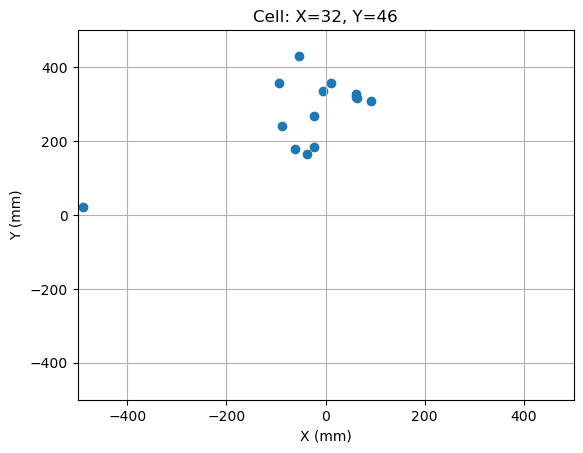

In [43]:
#Plot the cell with the maximum number of particles
cx = Particles.loc[Particles["Ncluster"]==55305,'DetX'].iloc[0]
cy = Particles.loc[Particles["Ncluster"]==55305,'DetY'].iloc[0]
Mx = Particles.loc[Particles["Ncluster"]==55305,'PartX']
My = Particles.loc[Particles["Ncluster"]==55305,'PartY']
plt.scatter(Mx,My)
plt.title('Cell: X=%i, Y=%i'%(cx,cy))
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
#Cell for detector of 1 m^2 
plt.axis([-500,500,-500,500])
#Cell for detector of 0.30 x 0.30 m^2
#plt.axis([-150,150,-150,150])
plt.grid(True)